### Setup and Imports

In [1]:
import os
import pandas as pd
import sqlite3  
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_24989/2470142701.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### Connect to the DB

In [5]:
db_path = "/Users/alexanderbenady/DataThesis/eu-legal-recommender/scraper/data/eurlex.db" 
conn = sqlite3.connect(db_path)

### Load Data into Pandas

In [6]:
conn = sqlite3.connect(db_path)
cursor = conn.execute("PRAGMA table_info(documents);")
for row in cursor.fetchall():
    print(row)

(0, 'document_id', 'INTEGER', 0, None, 1)
(1, 'celex_number', 'TEXT', 0, None, 0)
(2, 'title', 'TEXT', 0, None, 0)
(3, 'identifier', 'TEXT', 0, None, 0)
(4, 'eli_uri', 'TEXT', 0, None, 0)
(5, 'html_url', 'TEXT', 0, None, 0)
(6, 'pdf_url', 'TEXT', 0, None, 0)
(7, 'responsible_body_id', 'INTEGER', 0, None, 0)
(8, 'form_id', 'INTEGER', 0, None, 0)
(9, 'date_of_document', 'DATE', 0, None, 0)
(10, 'date_of_effect', 'DATE', 0, None, 0)
(11, 'date_of_end_validity', 'DATE', 0, None, 0)
(12, 'content', 'TEXT', 0, None, 0)
(13, 'content_html', 'TEXT', 0, None, 0)
(14, 'summary', 'TEXT', 0, None, 0)
(15, 'summary_word_count', 'INTEGER', 0, None, 0)
(16, 'total_words', 'INTEGER', 0, None, 0)
(17, 'compression_ratio', 'REAL', 0, None, 0)
(18, 'tier', 'INTEGER', 0, None, 0)


In [7]:
import sqlite3

conn = sqlite3.connect(db_path)
cursor = conn.execute("PRAGMA table_info(forms);")
for row in cursor.fetchall():
    print(row)

(0, 'form_id', 'INTEGER', 0, None, 1)
(1, 'form_name', 'TEXT', 0, None, 0)


In [8]:
sql_query_documents = """
SELECT 
    d.document_id,
    d.celex_number,
    d.title,
    d.identifier,
    d.eli_uri,
    d.html_url,
    d.pdf_url,
    rb.body_name  AS responsible_body,  
    f.form_name   AS form,              
    d.date_of_document,
    d.date_of_effect,
    d.content
FROM documents d
LEFT JOIN responsible_bodies rb ON d.responsible_body_id = rb.responsible_body_id
LEFT JOIN forms f ON d.form_id = f.form_id;

"""
df_docs = pd.read_sql_query(sql_query_documents, conn)

# Basic Data Inspection

### Row count

In [9]:
num_rows = len(df_docs)
print(f"Number of total documents in 'documents' table: {num_rows}")

Number of total documents in 'documents' table: 4166


### Check for duplicates in celex_number

In [10]:
duplicates_celex = df_docs['celex_number'].duplicated().sum()
print(f"Number of duplicate celex_number entries: {duplicates_celex}")

Number of duplicate celex_number entries: 0


### Missing data report

In [11]:
missing_report = df_docs.isnull().sum()
print("Missing values per column:\n", missing_report)

Missing values per column:
 document_id            0
celex_number           0
title                  0
identifier             0
eli_uri                0
html_url               0
pdf_url                0
responsible_body    2320
form                   1
date_of_document       0
date_of_effect      1202
content                1
dtype: int64


In [12]:
missing_percent = df_docs.isnull().mean() * 100
print("\nPercentage of missing values:\n", missing_percent)


Percentage of missing values:
 document_id          0.000000
celex_number         0.000000
title                0.000000
identifier           0.000000
eli_uri              0.000000
html_url             0.000000
pdf_url              0.000000
responsible_body    55.688910
form                 0.024004
date_of_document     0.000000
date_of_effect      28.852616
content              0.024004
dtype: float64


In [13]:
df_docs['missing_date_of_effect'] = df_docs['date_of_effect'].isnull()
pivot_missing = df_docs.pivot_table(
    values='missing_date_of_effect',
    index='form',
    aggfunc='mean'
).sort_values(by='missing_date_of_effect', ascending=False)
print("\nAverage fraction of missing `date_of_effect` by form:\n", pivot_missing)


Average fraction of missing `date_of_effect` by form:
                                                     missing_date_of_effect
form                                                                      
Declaration                                                       1.000000
Resolution                                                        1.000000
Recommendation adopted by bodies created by int...                1.000000
Recommendation                                                    1.000000
Notice                                                            1.000000
Decision adopted by bodies created by internati...                0.880392
International agreement                                           0.406250
Protocol to the agreement                                         0.250000
Decision                                                          0.125428
Regulation adopted by bodies created by interna...                0.111111
Rules of procedure                          

In [14]:
df_docs['missing_responsible_body'] = df_docs['responsible_body'].isnull()
pivot_missing = df_docs.pivot_table(
    values='missing_responsible_body',
    index='form',
    aggfunc='mean'
).sort_values(by='missing_responsible_body', ascending=False)
print("\nAverage fraction of missing `responsible_body` by form:\n", pivot_missing)


Average fraction of missing `responsible_body` by form:
                                                     missing_responsible_body
form                                                                        
Interinstitutional agreement                                        1.000000
International agreement                                             1.000000
Resolution                                                          1.000000
Regulation adopted by bodies created by interna...                  1.000000
Recommendation adopted by bodies created by int...                  1.000000
Protocol to the agreement                                           1.000000
Notice                                                              1.000000
Supplementary and amending budget                                   1.000000
Guideline                                                           1.000000
Declaration                                                         1.000000
Decision adopted b

# Basic Plots and Visuals

### Distribution of responsible body

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_24989/616391335.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_bodies.index, y=top_bodies.values, palette="Blues_r")


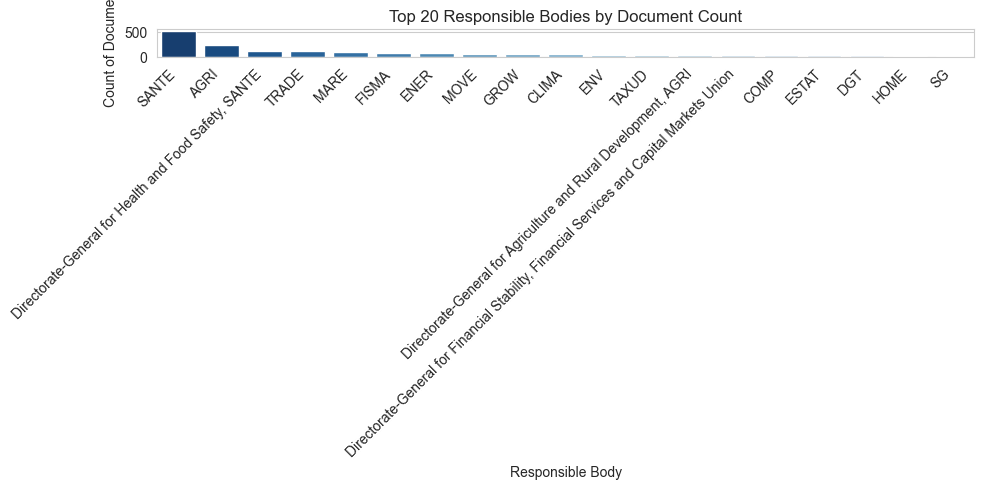

In [16]:
body_counts = df_docs['responsible_body'].value_counts(dropna=False)
top_n = 20
top_bodies = body_counts.head(top_n)
plt.figure(figsize=(10,5))
sns.barplot(x=top_bodies.index, y=top_bodies.values, palette="Blues_r")
plt.title(f"Top {top_n} Responsible Bodies by Document Count")
plt.xlabel("Responsible Body")
plt.ylabel("Count of Documents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [17]:
print(top_bodies)

responsible_body
None                                                                                         2320
SANTE                                                                                         516
AGRI                                                                                          232
Directorate-General for Health and Food Safety, SANTE                                         119
TRADE                                                                                         106
MARE                                                                                           83
FISMA                                                                                          68
ENER                                                                                           67
MOVE                                                                                           59
GROW                                                                                           56
CLI

### Distribution of Forms

In [19]:
!pip install textwrap

ERROR: Could not find a version that satisfies the requirement textwrap (from versions: none)
ERROR: No matching distribution found for textwrap

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


                                                 form  doc_count
0   Decision adopted by bodies created by internat...       1020
1                             Implementing regulation        996
2                                            Decision        877
3                               Implementing decision        382
4                                          Regulation        322
5                                Delegated regulation        221
6                                      Recommendation         64
7                                           Directive         60
8                                          Resolution         57
9                                              Notice         48
10                            International agreement         32
11                                          Guideline         16
12                                 Rules of procedure         12
13                                Delegated directive         11
14                       

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_24989/3659816533.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_forms, x="form_wrapped", y="doc_count", palette="viridis")


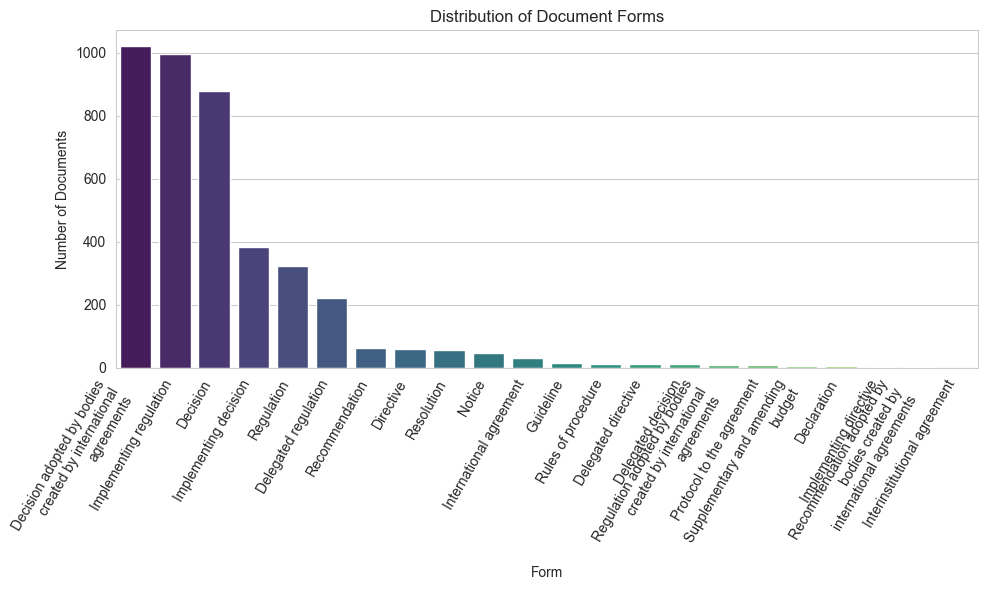

In [23]:
df_forms = pd.read_sql_query("""
    SELECT 
        f.form_name AS form,
        COUNT(d.document_id) AS doc_count
    FROM documents d
    LEFT JOIN forms f ON d.form_id = f.form_id
    GROUP BY f.form_id
    ORDER BY doc_count DESC
""", conn)

print(df_forms)

import textwrap

df_forms = df_forms[df_forms['form'].notna()]
df_forms['form_wrapped'] = df_forms['form'].apply(
    lambda x: "\n".join(textwrap.wrap(x, width=30))
)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_forms, x="form_wrapped", y="doc_count", palette="viridis")
plt.title("Distribution of Document Forms")
plt.xlabel("Form")
plt.ylabel("Number of Documents")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()


### Responsible Body Analysis

                                     responsible_body  doc_count
0                                                None       2320
1                                               SANTE        516
2                                                AGRI        232
3   Directorate-General for Health and Food Safety...        119
4                                               TRADE        106
..                                                ...        ...
69                                          EP_TRANSL          1
70                                              REGIO          1
71                      Directorate-General for Trade          1
72                                      Legal service          1
73                                               EMPL          1

[74 rows x 2 columns]


/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_24989/1693855897.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_body[:10], x="responsible_body", y="doc_count", palette="Blues_r")


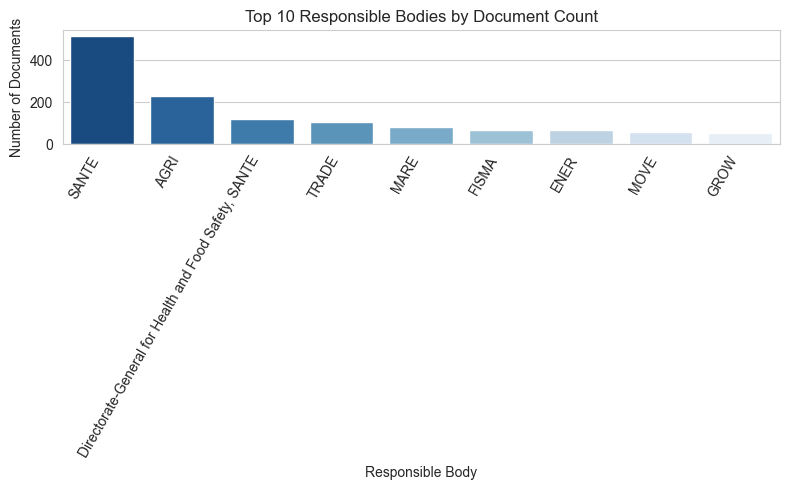

In [22]:
df_body = pd.read_sql_query("""
    SELECT 
        rb.body_name AS responsible_body,
        COUNT(d.document_id) AS doc_count
    FROM documents d
    LEFT JOIN responsible_bodies rb 
           ON d.responsible_body_id = rb.responsible_body_id
    GROUP BY rb.responsible_body_id
    ORDER BY doc_count DESC
""", conn)

print(df_body)

plt.figure(figsize=(8,5))
sns.barplot(data=df_body[:10], x="responsible_body", y="doc_count", palette="Blues_r")
plt.title("Top 10 Responsible Bodies by Document Count")
plt.xlabel("Responsible Body")
plt.ylabel("Number of Documents")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

### Potential correlation example: form vs. responsible_body

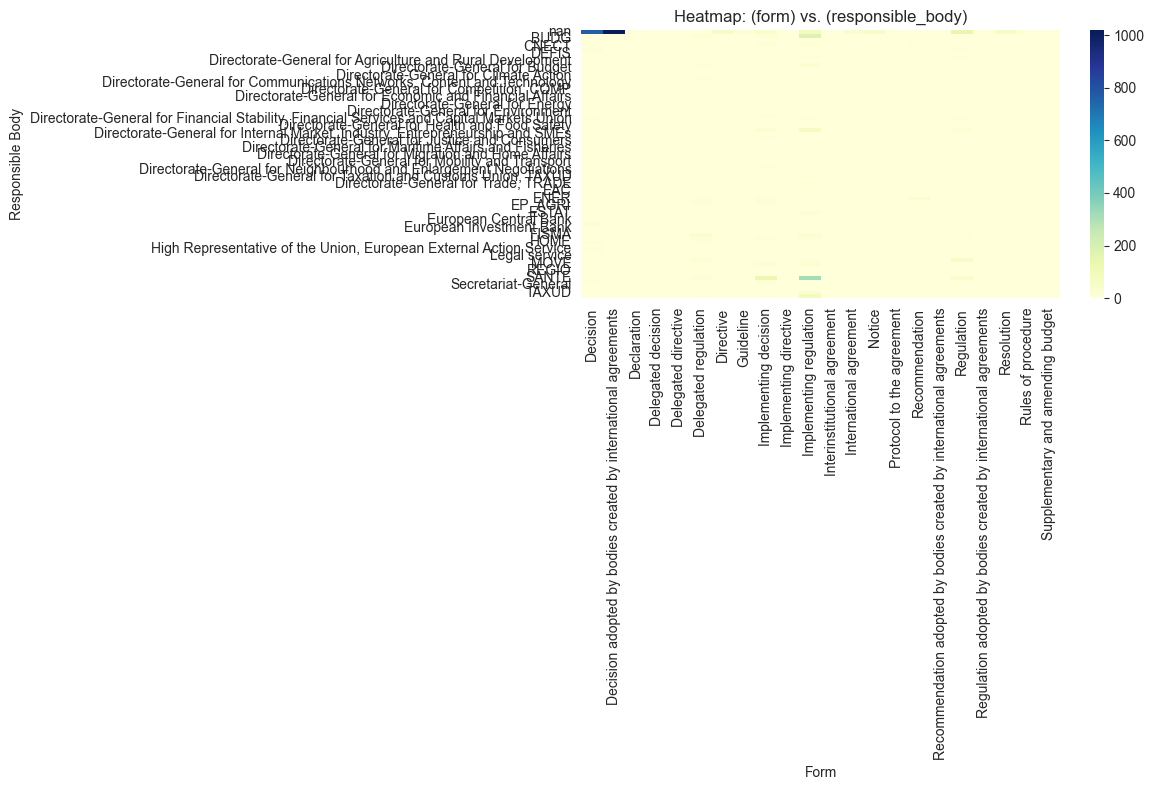

In [28]:
df_form_body = pd.read_sql_query("""
    SELECT 
        f.form_name AS form,
        rb.body_name AS responsible_body,
        COUNT(d.document_id) AS cnt
    FROM documents d
    LEFT JOIN forms f 
           ON d.form_id = f.form_id
    LEFT JOIN responsible_bodies rb
           ON d.responsible_body_id = rb.responsible_body_id
    GROUP BY f.form_id, rb.responsible_body_id
""", conn)

df_pivot_form_body = df_form_body.pivot(
    index="responsible_body",
    columns="form",
    values="cnt"
).fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot_form_body, annot=False, cmap="YlGnBu", cbar=True)
plt.title("Heatmap: (form) vs. (responsible_body)")
plt.xlabel("Form")
plt.ylabel("Responsible Body")
plt.tight_layout()
plt.show()

### Authors Analysis


Top Authors by Frequency:
                                          author_name  doc_count
0                                European Commission       1779
1                      Council of the European Union       1004
2                                EEA Joint Committee        972
3     Directorate-General for Health and Food Safety        632
4                                European Parliament        357
5  Directorate-General for Agriculture and Rural ...        266
6                      Directorate-General for Trade        115
7  Directorate-General for Maritime Affairs and F...         94
8       Financial Services and Capital Markets Union         82
9        Directorate-General for Financial Stability         82


/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_24989/1575162268.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_authors.head(10), x="author_name", y="doc_count", palette="rocket")


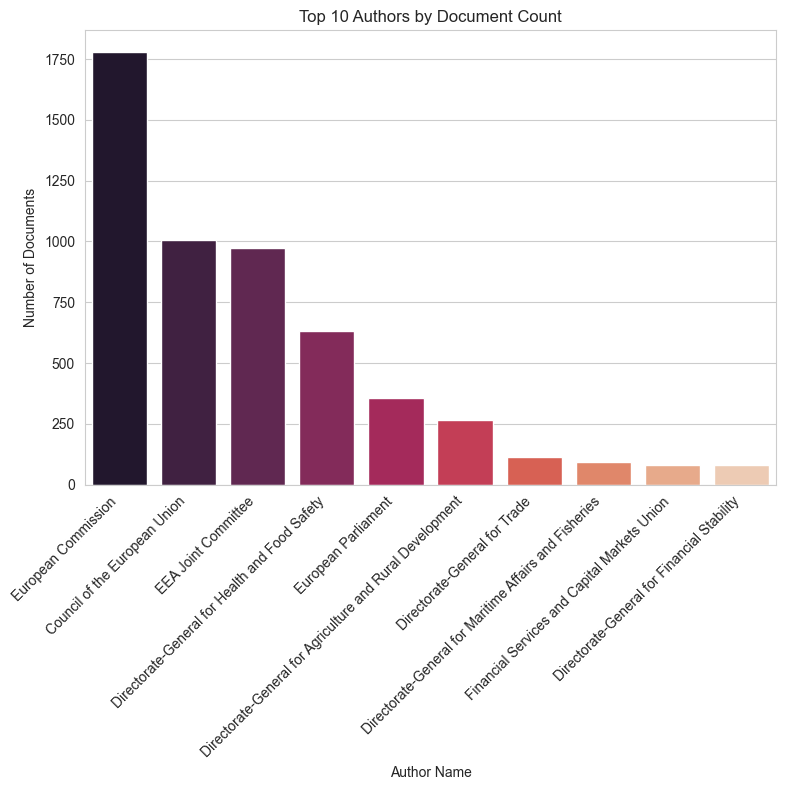

In [26]:
df_authors = pd.read_sql_query("""
    SELECT a.name AS author_name,
           COUNT(da.document_id) AS doc_count
    FROM authors AS a
    JOIN document_authors AS da ON a.author_id = da.author_id
    GROUP BY a.author_id
    ORDER BY doc_count DESC
""", conn)

print("\nTop Authors by Frequency:\n", df_authors.head(10))

plt.figure(figsize=(8,8))
sns.barplot(data=df_authors.head(10), x="author_name", y="doc_count", palette="rocket")
plt.title("Top 10 Authors by Document Count")
plt.xlabel("Author Name")
plt.ylabel("Number of Documents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Co-authorship pairs

In [30]:
df_coauthors = pd.read_sql_query("""
WITH doc_author_pairs AS (
    SELECT da1.author_id AS author1,
           da2.author_id AS author2,
           da1.document_id
      FROM document_authors da1
      JOIN document_authors da2 
        ON da1.document_id = da2.document_id
       AND da1.author_id < da2.author_id  -- avoid duplicates
)
SELECT a1.name AS author1_name,
       a2.name AS author2_name,
       COUNT(doc_author_pairs.document_id) AS cooccurrence_count
FROM doc_author_pairs
JOIN authors a1 ON author1 = a1.author_id
JOIN authors a2 ON author2 = a2.author_id
GROUP BY author1, author2
ORDER BY cooccurrence_count DESC
""", conn)
print("\nTop Co-Author Pairs:\n", df_coauthors.head(10))


Top Co-Author Pairs:
                                   author1_name  \
0                          European Commission   
1                          European Commission   
2                Council of the European Union   
3                          European Commission   
4                          European Commission   
5                          European Commission   
6                          European Commission   
7  Directorate-General for Financial Stability   
8                          European Commission   
9                          European Commission   

                                        author2_name  cooccurrence_count  
0     Directorate-General for Health and Food Safety                 632  
1  Directorate-General for Agriculture and Rural ...                 266  
2                                European Parliament                 185  
3                      Directorate-General for Trade                 115  
4  Directorate-General for Maritime Affairs and F..

### EuroVoc Descriptors Analysis


Top 10 EuroVoc Descriptors by Frequency:
             descriptor_name  doc_count
0  revision of an agreement       1070
1    European Economic Area        972
2           market approval        625
3                 labelling        340
4               import (EU)        319
5        technical standard        284
6    EU restrictive measure        282
7               food safety        280
8        economic sanctions        279
9   international sanctions        279


/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_24989/1907120964.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_descriptors.head(10), x="descriptor_name", y="doc_count", palette="magma")


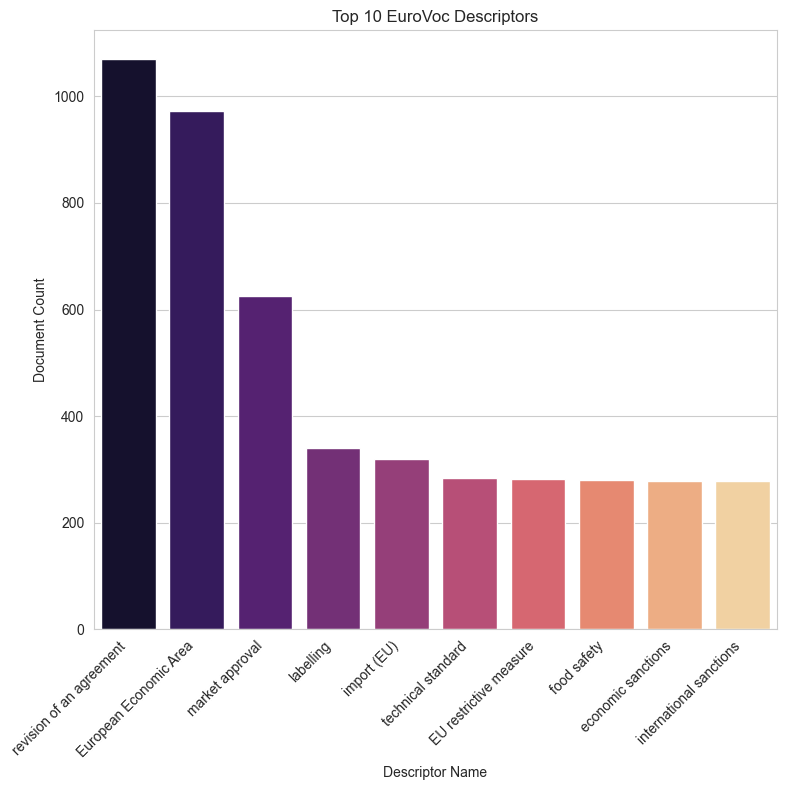

In [27]:
df_descriptors = pd.read_sql_query("""
    SELECT e.descriptor_name,
           COUNT(ded.document_id) AS doc_count
    FROM eurovoc_descriptors e
    JOIN document_eurovoc_descriptors ded
         ON e.descriptor_id = ded.descriptor_id
    GROUP BY e.descriptor_id
    ORDER BY doc_count DESC
""", conn)

print("\nTop 10 EuroVoc Descriptors by Frequency:\n", df_descriptors.head(10))

plt.figure(figsize=(8,8))
sns.barplot(data=df_descriptors.head(10), x="descriptor_name", y="doc_count", palette="magma")
plt.title("Top 10 EuroVoc Descriptors")
plt.xlabel("Descriptor Name")
plt.ylabel("Document Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Subject Matters Analysis


Subject Matters Distribution:
                                           subject_name  doc_count
0               European Free Trade Association (EFTA)       1004
1                   Common foreign and security policy        446
2                                   External relations        419
3                         Internal market - Principles        356
4                                  Consumer protection        256
..                                                 ...        ...
202  Economic, financial and technical cooperation ...          1
203    European Central Bank (ECB)/Banking supervision          1
204  European Central Bank (ECB)/Banking supervisio...          1
205                                   Humanitarian aid          1
206  European Central Bank (ECB)/Banking supervisio...          1

[207 rows x 2 columns]


/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_88992/202296234.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_subjects.head(10), x="subject_name", y="doc_count", palette="coolwarm")
/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_88992/202296234.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


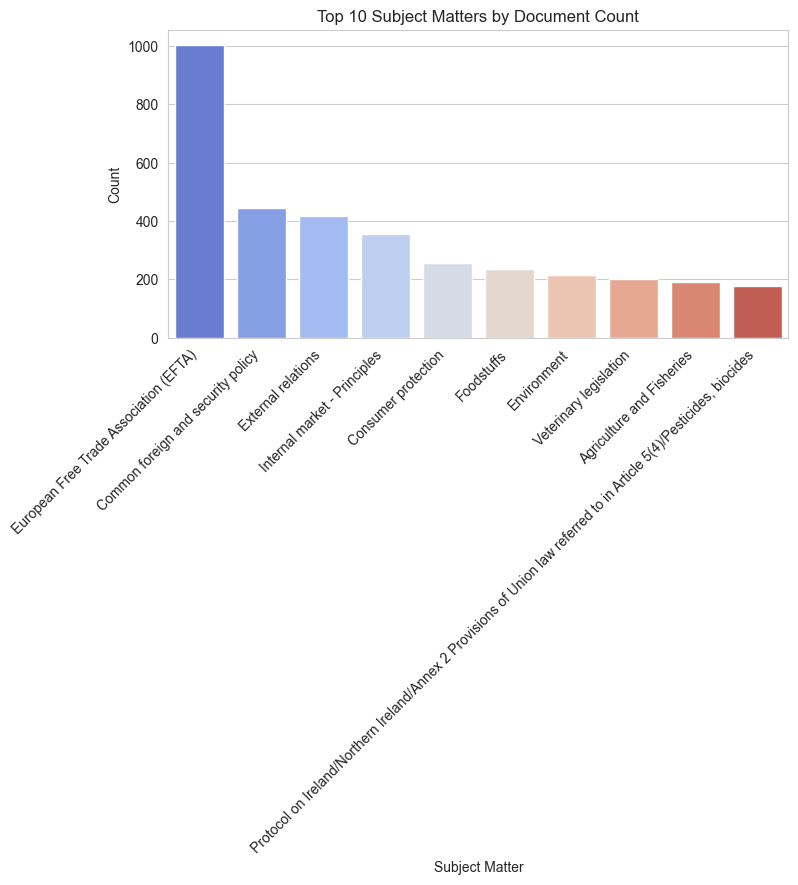

In [34]:
df_subjects = pd.read_sql_query("""
    SELECT sm.subject_name,
           COUNT(dsm.document_id) as doc_count
    FROM subject_matters sm
    JOIN document_subject_matters dsm
         ON sm.subject_id = dsm.subject_id
    GROUP BY sm.subject_id
    ORDER BY doc_count DESC
""", conn)

print("\nSubject Matters Distribution:\n", df_subjects)

plt.figure(figsize=(8,4))
sns.barplot(data=df_subjects.head(10), x="subject_name", y="doc_count", palette="coolwarm")
plt.title("Top 10 Subject Matters by Document Count")
plt.xlabel("Subject Matter")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Potential correlation: subject matters vs. form

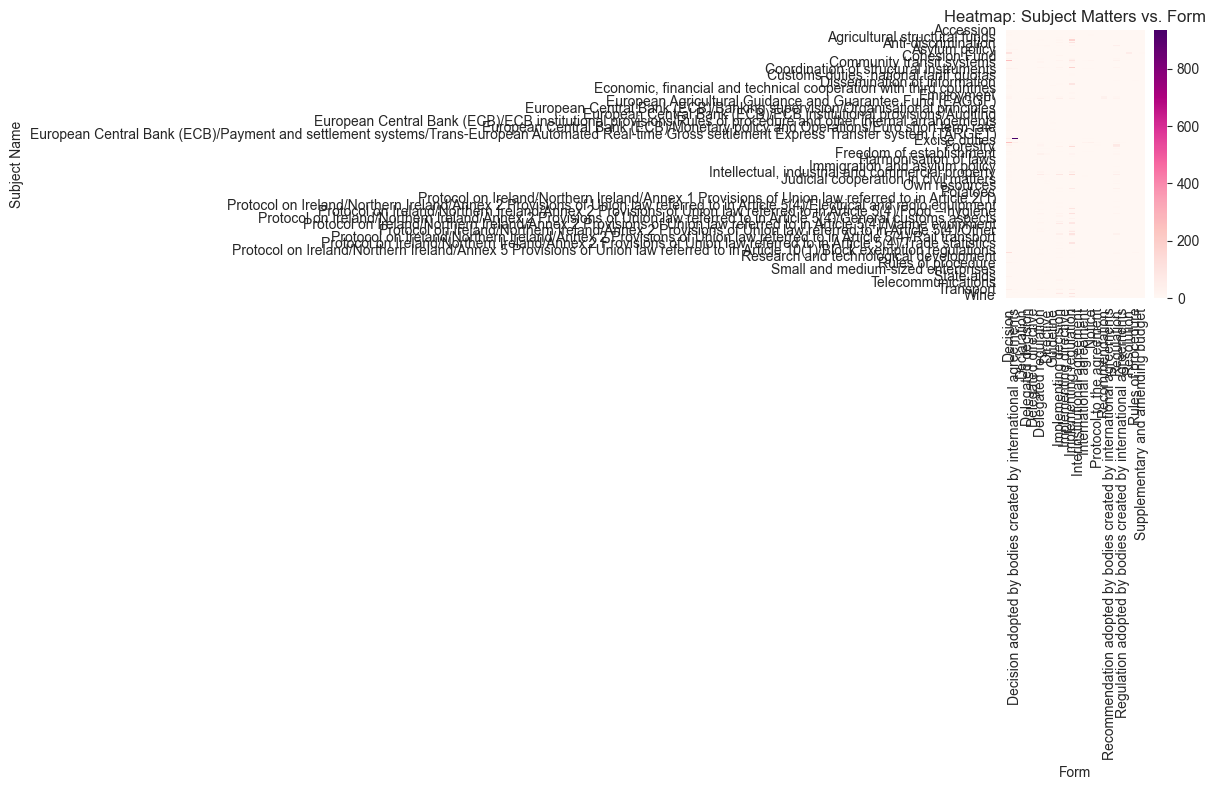

In [36]:
df_subj_form = pd.read_sql_query("""
    SELECT 
        f.form_name  AS form,
        sm.subject_name,
        COUNT(*) AS doc_count
    FROM documents d
    LEFT JOIN forms f
           ON d.form_id = f.form_id
    JOIN document_subject_matters dsm
         ON d.document_id = dsm.document_id
    JOIN subject_matters sm
         ON dsm.subject_id = sm.subject_id
    GROUP BY f.form_name, sm.subject_name
""", conn)

df_pivot_subj_form = df_subj_form.pivot(
    index="subject_name", 
    columns="form", 
    values="doc_count"
).fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(df_pivot_subj_form, annot=False, cmap="RdPu", cbar=True)
plt.title("Heatmap: Subject Matters vs. Form")
plt.xlabel("Form")
plt.ylabel("Subject Name")
plt.tight_layout()
plt.show()

### Directory Codes Analysis


Directory Codes Frequency:
   directory_code  doc_count
0    11.40.10.10       1017
1    18.00.00.00        446
2    03.50.30.00        200
3    15.20.20.00        183
4    01.60.20.00        175
5    13.30.99.00        161
6    03.50.10.00        125
7    13.30.14.00        125
8    03.50.20.00        119
9    15.10.20.30        118


/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_88992/433036655.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_dir.head(10), x="directory_code", y="doc_count", palette="viridis")


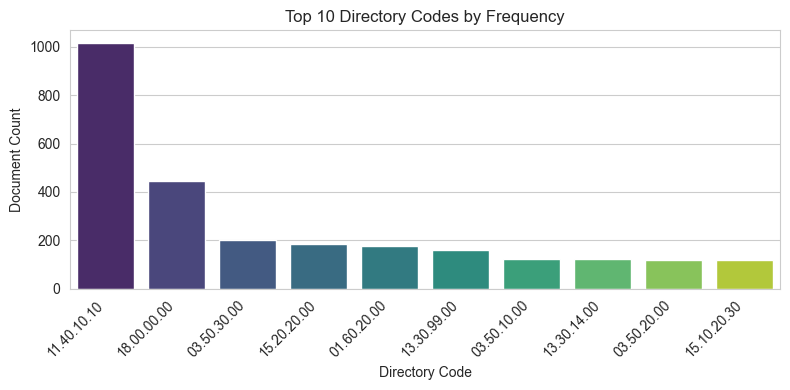

In [39]:
df_dir = pd.read_sql_query("""
    SELECT dc.directory_code,
           COUNT(ddc.document_id) AS doc_count
    FROM directory_codes dc
    JOIN document_directory_codes ddc
         ON dc.directory_id = ddc.directory_id
    GROUP BY dc.directory_id
    ORDER BY doc_count DESC
""", conn)

print("\nDirectory Codes Frequency:\n", df_dir.head(10))

plt.figure(figsize=(8,4))
sns.barplot(data=df_dir.head(10), x="directory_code", y="doc_count", palette="viridis")
plt.title("Top 10 Directory Codes by Frequency")
plt.xlabel("Directory Code")
plt.ylabel("Document Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Load Document Data with Date Fields

In [28]:
df_dates = pd.read_sql_query("""
    SELECT 
        d.document_id,
        f.form_name AS form,
        d.date_of_document,
        d.date_of_effect,
        d.date_of_end_validity
    FROM documents d
    LEFT JOIN forms f 
           ON d.form_id = f.form_id
""", conn)

conn.close()

df_dates['date_of_document'] = pd.to_datetime(df_dates['date_of_document'], errors='coerce')
df_dates['date_of_effect'] = pd.to_datetime(df_dates['date_of_effect'], errors='coerce')
df_dates['date_of_end_validity'] = pd.to_datetime(df_dates['date_of_end_validity'], errors='coerce')


### Trends and Seasonality

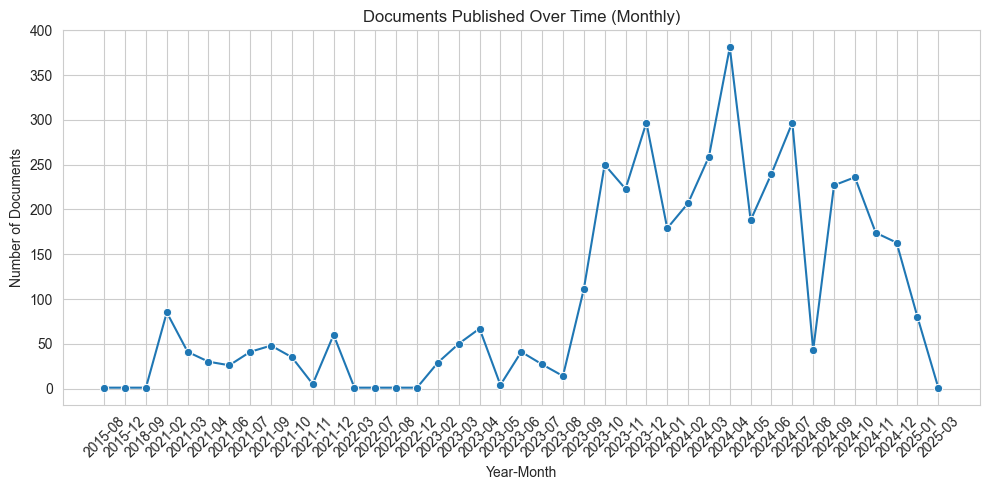

In [29]:
df_dates['year_month'] = df_dates['date_of_document'].dt.to_period('M')

doc_counts_monthly = (
    df_dates.dropna(subset=['year_month'])
    .groupby('year_month')['document_id']
    .count()
    .rename('doc_count')
    .reset_index()
)

doc_counts_monthly['year_month'] = doc_counts_monthly['year_month'].astype(str)  # Convert period to string for plotting

plt.figure(figsize=(10,5))
sns.lineplot(data=doc_counts_monthly, x="year_month", y="doc_count", marker='o')
plt.title("Documents Published Over Time (Monthly)")
plt.xlabel("Year-Month")
plt.ylabel("Number of Documents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_88992/2174045004.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_seasonality, x='month', y='doc_count', palette="viridis")


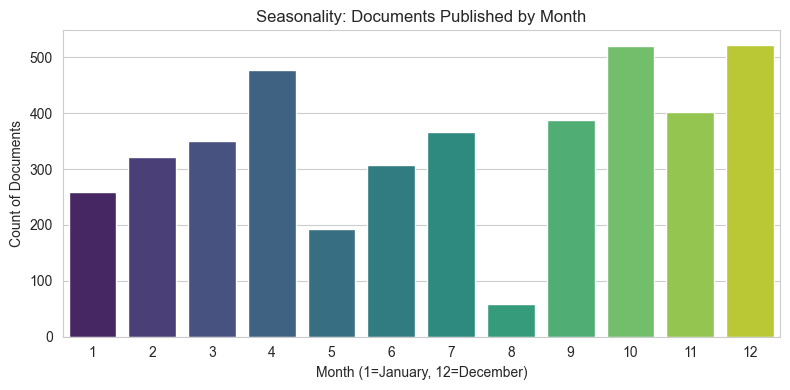

In [48]:
df_dates['month'] = df_dates['date_of_document'].dt.month
monthly_seasonality = (
    df_dates.dropna(subset=['month'])
    .groupby('month')['document_id']
    .count()
    .reset_index(name='doc_count')
)

plt.figure(figsize=(8,4))
sns.barplot(data=monthly_seasonality, x='month', y='doc_count', palette="viridis")
plt.title("Seasonality: Documents Published by Month")
plt.xlabel("Month (1=January, 12=December)")
plt.ylabel("Count of Documents")
plt.tight_layout()
plt.show()

# EDA on the Text Field

### Document Length Analysis

In [31]:
conn = sqlite3.connect(db_path)

# Example: Load documents + form text into df_text
df_text = pd.read_sql_query("""
    SELECT
        d.document_id,
        f.form_name AS form,
        d.content
    FROM documents d
    LEFT JOIN forms f ON d.form_id = f.form_id
""", conn)

conn.close()

In [32]:
df_text['length_chars'] = df_text['content'].apply(lambda x: len(x) if x else 0)
df_text['length_words'] = df_text['content'].apply(lambda x: len(x.split()) if x else 0)

print("Character Length Stats:")
print(df_text['length_chars'].describe())
print("\nWord Count Stats:")
print(df_text['length_words'].describe())

Character Length Stats:
count    4.166000e+03
mean     2.491003e+05
std      8.283201e+05
min      0.000000e+00
25%      2.240050e+04
50%      5.216450e+04
75%      1.486300e+05
max      2.465296e+07
Name: length_chars, dtype: float64

Word Count Stats:
count    4.166000e+03
mean     3.484346e+04
std      1.124079e+05
min      0.000000e+00
25%      3.223000e+03
50%      7.572000e+03
75%      2.090050e+04
max      2.972533e+06
Name: length_words, dtype: float64


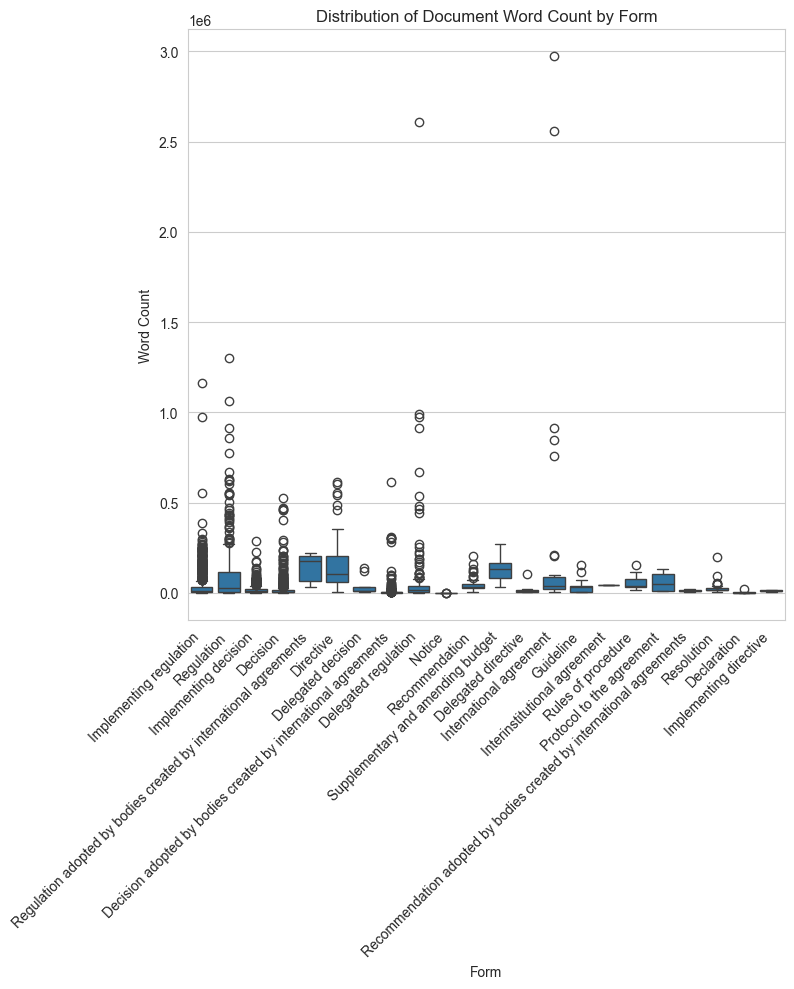

/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_24989/1144407761.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')


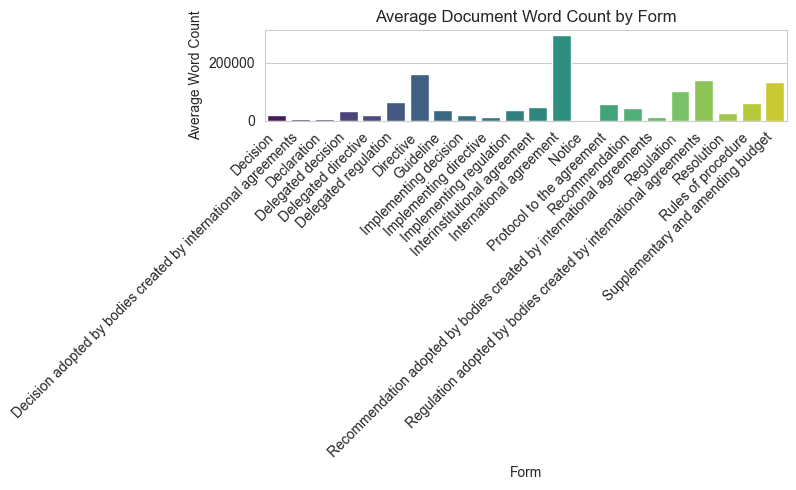

In [33]:
plt.figure(figsize=(8,10))
sns.boxplot(data=df_text, x='form', y='length_words')
plt.title("Distribution of Document Word Count by Form")
plt.xlabel("Form")
plt.ylabel("Word Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

avg_length_by_form = df_text.groupby('form')['length_words'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=avg_length_by_form, x='form', y='length_words', palette='viridis')
plt.title("Average Document Word Count by Form")
plt.xlabel("Form")
plt.ylabel("Average Word Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Basic NLP Stats - Word Frequency

In [35]:
!pip install nltk scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [36]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderbenady/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alexanderbenady/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [38]:
stop_words = set(stopwords.words('english'))

def tokenize_and_clean(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

all_tokens = []

for content in df_text['content'].fillna(''):
    tokens = tokenize_and_clean(content)
    all_tokens.extend(tokens)

### Top unigrams


Top 20 Unigrams:
 [('shall', 929084), ('article', 840211), ('regulation', 810297), ('eu', 702684), ('union', 515969), ('european', 509429), ('commission', 506396), ('member', 436503), ('information', 330730), ('council', 298862), ('following', 298276), ('accordance', 286834), ('referred', 263965), ('may', 260444), ('states', 257044), ('decision', 254931), ('b', 248067), ('annex', 244193), ('data', 238512), ('point', 237316)]


/var/folders/b6/ws8j5sfs77lfzscpjk2_05nm0000gn/T/ipykernel_24989/2132712210.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=unigrams_df, x='token', y='count', palette='plasma')


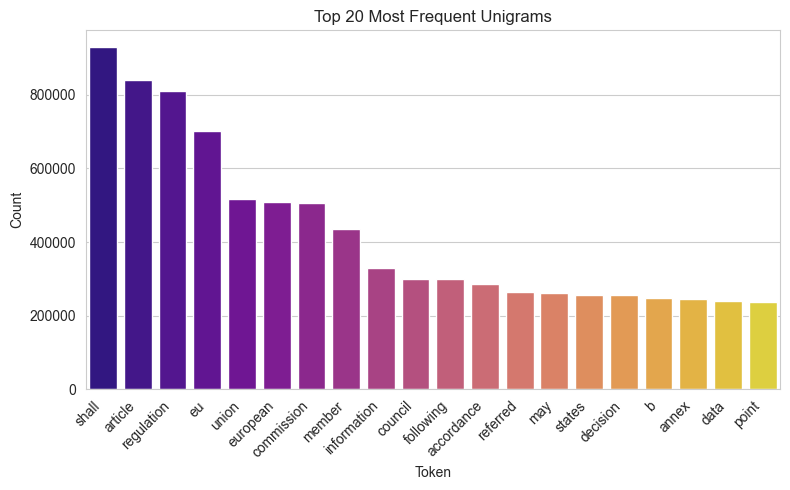

In [39]:
top_unigrams = Counter(all_tokens).most_common(20)
print("\nTop 20 Unigrams:\n", top_unigrams)

unigrams_df = pd.DataFrame(top_unigrams, columns=['token', 'count'])
plt.figure(figsize=(8,5))
sns.barplot(data=unigrams_df, x='token', y='count', palette='plasma')
plt.title("Top 20 Most Frequent Unigrams")
plt.xlabel("Token")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Top bigrams

In [40]:
vectorizer_bi = CountVectorizer(
    stop_words='english',
    ngram_range=(2,2),
    min_df=2  
)

corpus = df_text['content'].fillna('').tolist()
X_bigrams = vectorizer_bi.fit_transform(corpus)
bigram_counts = np.asarray(X_bigrams.sum(axis=0)).flatten()
bigram_vocab = vectorizer_bi.get_feature_names_out()

bigram_freq = sorted(
    zip(bigram_vocab, bigram_counts),
    key=lambda x: x[1],
    reverse=True
)[:20]

print("\nTop 20 Bigrams:\n", bigram_freq)

bigram_df = pd.DataFrame(bigram_freq, columns=['bigram', 'count'])
plt.figure(figsize=(10,5))
sns.barplot(data=bigram_df, x='bigram', y='count', palette='magma')
plt.title("Top 20 Bigrams")
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

### Top Trigrams

In [ ]:
vectorizer_tri = CountVectorizer(
    stop_words='english',
    ngram_range=(3,3),
    min_df=2
)
X_trigrams = vectorizer_tri.fit_transform(corpus)
trigram_counts = np.asarray(X_trigrams.sum(axis=0)).flatten()
trigram_vocab = vectorizer_tri.get_feature_names_out()

trigram_freq = sorted(
    zip(trigram_vocab, trigram_counts),
    key=lambda x: x[1],
    reverse=True
)[:20]
print("\nTop 20 Trigrams:\n", trigram_freq)